In [84]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [102]:
# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data() #Ignoring Labels as we are performing Reconstruction
x_train, x_test = x_train.astype('float32') / 255., x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [98]:
class Encoder(layers.Layer):
    def __init__(self, latent_dim=2):
        super(Encoder, self).__init__()
        self.conv1 = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')
        self.conv2 = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')
        self.flatten = layers.Flatten()
        self.d = layers.Dense(latent_dim + latent_dim)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.d(x)
        return x

In [99]:
class Decoder(layers.Layer):
    def __init__(self, latent_dim=2):
        super(Decoder, self).__init__()
        self.dense = layers.Dense(7*7*64, activation='relu')
        self.reshape = layers.Reshape((7, 7, 64))
        self.convT1 = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')
        self.convT2 = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')
        self.convT3 = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')

    def call(self, z):
        z = self.dense(z)
        z = self.reshape(z)
        z = self.convT1(z)
        z = self.convT2(z)
        z = self.convT3(z)
        return z

In [100]:
class VAE(Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def call(self, x):
        encoded = self.encoder(x)
        z_mean, z_log_var = tf.split(encoded, num_or_size_splits=2, axis=1)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        kl_coefficient = 0.001  # Example coefficient, adjust based on experimentation.
        self.add_loss(kl_coefficient * kl_loss)
        return reconstructed

    def reparameterize(self, z_mean, z_log_var):
        eps = tf.random.normal(shape=(tf.shape(z_mean)[0], self.latent_dim))
        return eps * tf.exp(z_log_var * .5) + z_mean

In [104]:
latent_dim = 16

vae = VAE(latent_dim)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.MeanSquaredError())
vae.fit(x_train, x_train, epochs=1, batch_size=64, validation_data=(x_test, x_test))

938/938 [==============================] - 60s 63ms/step - loss: 0.0315 - val_loss: 0.0152


In [105]:
predictions = vae.predict(x_test)
mse = np.mean(np.square(x_test - predictions))
print("Test MSE:", mse)


313/313 [==============================] - 5s 14ms/step
Test MSE: 0.012541366


157/157 [==============================] - 3s 21ms/step


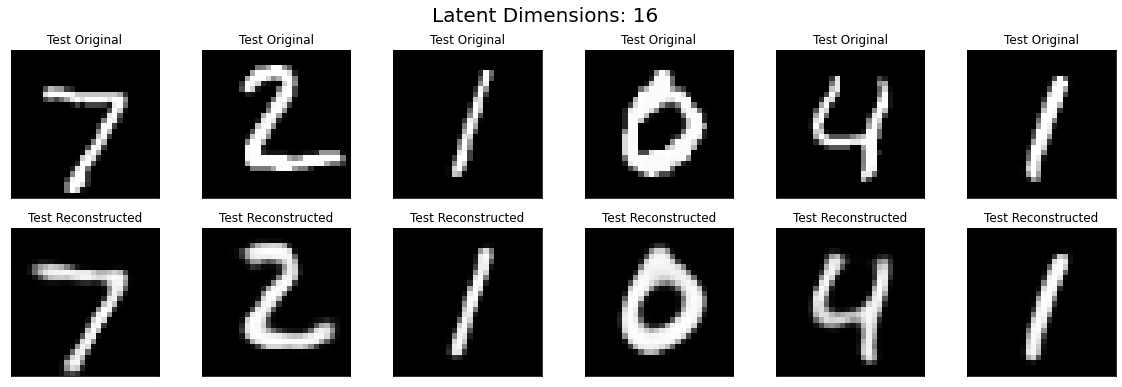

In [110]:
def plot_images(original, reconstructed, latent_dim):
    n = 6 # Number of digits to display
    plt.figure(figsize=(20, 6))
    title = f'Latent Dimensions: {latent_dim}'
    plt.suptitle(title, fontsize=20)
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28))
        plt.title("Test Original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(28, 28))
        plt.title("Test Reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Predict and visualize the reconstruction
x_test_encoded = vae.predict(x_test, batch_size=64)
plot_images(x_test, x_test_encoded,latent_dim)